In [ ]:
!pip install -q split-folders
import splitfolders
import os
import shutil
import random
import csv
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
from pathlib import Path
import pandas as pd
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.applications import ResNet50, InceptionV3
from tensorflow import keras as K
from tensorflow.keras.applications.xception import Xception
from keras import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras import regularizers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to the main folder and the destination folder
destination_folder = '/content/drive/MyDrive/Multiclass'

# Split the main folder into train and validation sets in a ratio
def split():  
    splitfolders.ratio('/content/drive/MyDrive/Multiclass/data_threshold', output = destination_folder,
                       seed = 22, ratio = (0.7, 0.15, 0.15), group_prefix = None, move = False)

if os.path.exists('/content/drive/MyDrive/Multiclass/train'):
    print("Files already present in splitted ratio 0.7, 0.15 and 0.15")
else:
    split()
    print("Files are splitted in the ratio 0.7, 0.15 and 0.15")

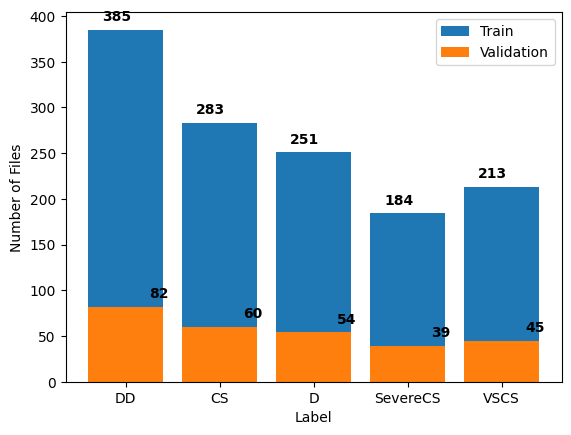

In [ ]:
train_dir = '/content/drive/MyDrive/Multiclass/train'
val_dir = '/content/drive/MyDrive/Multiclass/val'
test_dir = '/content/drive/MyDrive/Multiclass/test'

train_labels = []
train_counts = []
val_labels = []
val_counts = []
test_labels = []
test_counts = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        train_labels.append(label)
        train_counts.append(len(os.listdir(label_dir)))

for label in os.listdir(val_dir):
    label_dir = os.path.join(val_dir, label)
    if os.path.isdir(label_dir):
        val_labels.append(label)
        val_counts.append(len(os.listdir(label_dir)))

fig, ax = plt.subplots()
ax.bar(train_labels, train_counts, label = 'Train')
ax.bar(val_labels, val_counts, label = 'Validation')
ax.set_xlabel('Label')
ax.set_ylabel('Number of Files')

for i, v in enumerate(train_counts):
    ax.text(i - 0.25, v + 10, str(v), fontweight = 'bold')
for i, v in enumerate(val_counts):
    ax.text(i + 0.25, v + 10, str(v), fontweight = 'bold') 
    
    
ax.legend()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 10, fill_mode='constant', cval=0)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(310, 310), batch_size=2, class_mode='categorical', shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(310, 310), batch_size=1, class_mode='categorical', shuffle=False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(310, 310), batch_size=1, class_mode='categorical', shuffle=False)

Found 1316 images belonging to 5 classes.
Found 280 images belonging to 5 classes.
Found 288 images belonging to 5 classes.


# **ResNet-50**

In [ ]:
# Load the ResNet50 model with pre-trained weights
model = ResNet50(weights='imagenet', include_top=False, input_shape=(310,310,3), classes=5)

# Freeze the layers of the model
for layer in model.layers:
    layer.trainable = False

# Add a new fully connected layer with the desired number of classes
#x = model.layers[-2].output
x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create a new model with the new output layer
resnet50_model = Model(inputs=model.input, outputs=predictions)

# Compile the model with a optimizer and loss function
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_resnet_best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

# set the number os steps of each epoch
validation_steps = val_generator.samples//1
training_steps = train_generator.samples//2 

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
history = resnet50_model.fit(train_generator, epochs = 40, validation_data = val_generator, callbacks = [checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/40
658/658 [==============================] - 643s 959ms/step - loss: 9.8011 - accuracy: 0.2622 - val_loss: 1.6013 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 2/40
658/658 [==============================] - 47s 71ms/step - loss: 1.6263 - accuracy: 0.2926 - val_loss: 1.5868 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 3/40
658/658 [==============================] - 43s 66ms/step - loss: 1.5841 - accuracy: 0.2926 - val_loss: 1.5801 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 4/40
658/658 [==============================] - 45s 68ms/step - loss: 1.5795 - accuracy: 0.2926 - val_loss: 1.5772 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 5/40
658/658 [==============================] - 47s 72ms/step - loss: 1.5778 - accuracy: 0.2926 - val_loss: 1.5760 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 6/40
658/658 [==============================] - 45s 69ms/step - loss: 1.5771 - accuracy: 0.2926 - val_loss: 1.5755 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 7/40
658/658 [==============================] - 43

0.2964285612106323


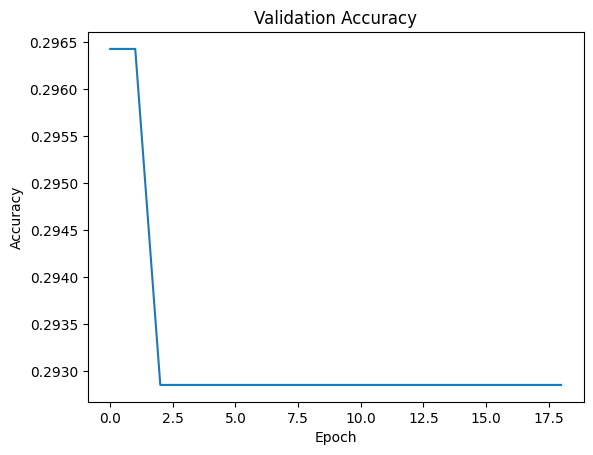

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_resnet_best_weights.h5')

# Extract the validation accuracy from the history object
val_acc = history.history['val_accuracy']
print(max(val_acc))

# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_generator.reset()
test_predictions = model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual validation labels:", len(actualLables_test))

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis = 1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy=model.evaluate(test_generator, batch_size=1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

288/288 [==============================] - 128s 444ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 288
[[ 0  0 62  0  0]
 [ 0  0 55  0  0]
 [ 0  0 83  0  0]
 [ 0  0 41  0  0]
 [ 0  0 47  0  0]]
288/288 [==============================] - 5s 16ms/step - loss: 1.6021 - accuracy: 0.2882
Test Loss:     1.6021482944488525
Test Accuracy: 0.2881944477558136


# **Inceptionv3**

In [ ]:
# Load the InceptionV3 model with pre-trained weights
model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False, classes=5)
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(5, activation = 'softmax')(InceptionV3_x)
inceptionv3_model = Model(inputs = model.input, outputs = InceptionV3_x)

# Compile the model with a optimizer and loss function
inceptionv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_inceptionv3_best_weights.h5',  # File to save the weights to
                             monitor='val_accuracy', save_best_only=True, mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
history = inceptionv3_model.fit(train_generator, epochs = 40, validation_data = val_generator, callbacks = [checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/40
658/658 [==============================] - 77s 95ms/step - loss: 6.1089 - accuracy: 0.2629 - val_loss: 1.5568 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 2/40
658/658 [==============================] - 72s 110ms/step - loss: 1.5321 - accuracy: 0.3184 - val_loss: 1.4144 - val_accuracy: 0.3286 - lr: 0.0010
Epoch 3/40
658/658 [==============================] - 70s 106ms/step - loss: 1.5106 - accuracy: 0.3343 - val_loss: 1.4012 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 4/40
658/658 [==============================] - 54s 82ms/step - loss: 1.4752 - accuracy: 0.3465 - val_loss: 1.4160 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/40
658/658 [==============================] - 50s 76ms/step - loss: 1.4666 - accuracy: 0.3435 - val_loss: 1.3938 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 6/40
658/658 [==============================] - 51s 78ms/step - loss: 1.4451 - accuracy: 0.3967 - val_loss: 1.6704 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 7/40
658/658 [==============================] - 50

0.5035714507102966


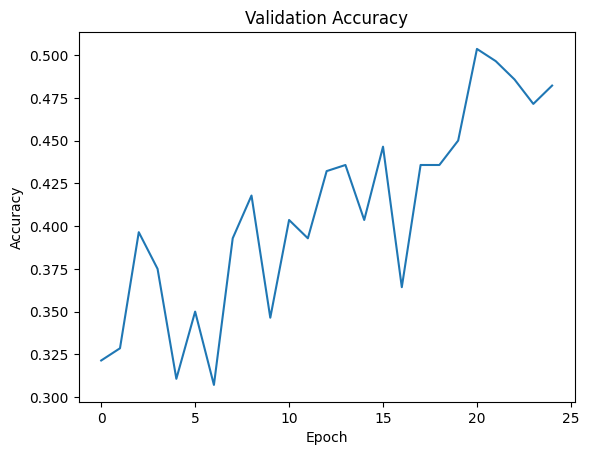

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_inceptionv3_best_weights.h5')

# Extract the validation accuracy from the history object
val_acc = history.history['val_accuracy']
print(max(val_acc))

# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_generator.reset()
test_predictions = model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual validation labels:", len(actualLables_test))

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis = 1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy=model.evaluate(test_generator, batch_size=1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

288/288 [==============================] - 6s 18ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 288
[[31  3 13  5 10]
 [ 9 22 23  1  0]
 [22 13 46  1  1]
 [18  0  2 13  8]
 [ 8  0  1  7 31]]
288/288 [==============================] - 6s 18ms/step - loss: 1.3390 - accuracy: 0.4965
Test Loss:     1.3389840126037598
Test Accuracy: 0.4965277910232544


# **Xception**

In [ ]:
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3), classes=5)

x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(5, activation = 'softmax')(x)

xception_model = Model(inputs = xception_model.input, outputs = x)

# Compile the model with a optimizer and loss function
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_xception_best_weights.h5',  # File to save the weights to
                             monitor='val_accuracy',  # Metric to monitor
                             save_best_only=True,  # Save only the best weights
                             mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
history = xception_model.fit(train_generator, epochs = 40, validation_data = val_generator, callbacks = [checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/40
658/658 [==============================] - 109s 117ms/step - loss: 1.7280 - accuracy: 0.2447 - val_loss: 1.6618 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/40
658/658 [==============================] - 80s 121ms/step - loss: 1.6246 - accuracy: 0.2652 - val_loss: 1.6644 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/40
658/658 [==============================] - 75s 114ms/step - loss: 1.7483 - accuracy: 0.2416 - val_loss: 1.5845 - val_accuracy: 0.2679 - lr: 0.0010
Epoch 4/40
658/658 [==============================] - 79s 120ms/step - loss: 1.6024 - accuracy: 0.2819 - val_loss: 1.5823 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/40
658/658 [==============================] - 66s 100ms/step - loss: 1.5966 - accuracy: 0.2774 - val_loss: 1.6002 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 6/40
658/658 [==============================] - 69s 105ms/step - loss: 1.5883 - accuracy: 0.2857 - val_loss: 1.6754 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 7/40
658/658 [==============================]

0.30000001192092896


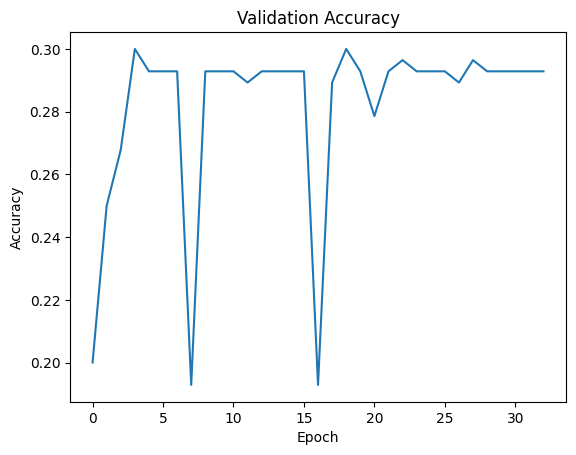

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_xception_best_weights.h5')

# Extract the validation accuracy from the history object
val_acc = history.history['val_accuracy']
print(max(val_acc))

# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_generator.reset()
test_predictions = model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual validation labels:", len(actualLables_test))

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis = 1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy=model.evaluate(test_generator, batch_size=1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

288/288 [==============================] - 4s 13ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 288
[[ 0  0 60  0  2]
 [ 0  0 55  0  0]
 [ 0  0 83  0  0]
 [ 0  0 40  0  1]
 [ 0  0 47  0  0]]
288/288 [==============================] - 6s 19ms/step - loss: 1.5935 - accuracy: 0.2882
Test Loss:     1.5935301780700684
Test Accuracy: 0.2881944477558136


# **VGG-16**

In [ ]:
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (310, 310, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)

vgg16_model = Model(vgg16_model.input, vgg_x)

# Compile the model with a optimizer and loss function
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/multiclass_vgg16_best_weights.h5',  # File to save the weights to
                             monitor='val_accuracy',  # Metric to monitor
                             save_best_only=True,  # Save only the best weights
                             mode='max')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a ReduceLROnPlateau callback with a factor of 0.1
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
history = vgg16_model.fit(train_generator, epochs = 40, validation_data = val_generator, callbacks = [checkpoint, lr_scheduler, early_stopping], verbose=1)

Epoch 1/40
658/658 [==============================] - 46s 66ms/step - loss: 1.6071 - accuracy: 0.2819 - val_loss: 1.5604 - val_accuracy: 0.2643 - lr: 0.0010
Epoch 2/40
658/658 [==============================] - 43s 65ms/step - loss: 1.5367 - accuracy: 0.3214 - val_loss: 1.5449 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 3/40
658/658 [==============================] - 47s 71ms/step - loss: 1.5244 - accuracy: 0.3047 - val_loss: 1.5462 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 4/40
658/658 [==============================] - 42s 64ms/step - loss: 1.4980 - accuracy: 0.3229 - val_loss: 1.5039 - val_accuracy: 0.3286 - lr: 0.0010
Epoch 5/40
658/658 [==============================] - 43s 65ms/step - loss: 1.4828 - accuracy: 0.3457 - val_loss: 1.4482 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 6/40
658/658 [==============================] - 48s 72ms/step - loss: 1.4662 - accuracy: 0.3450 - val_loss: 1.4536 - val_accuracy: 0.2929 - lr: 0.0010
Epoch 7/40
658/658 [==============================] - 42s 

0.38928571343421936


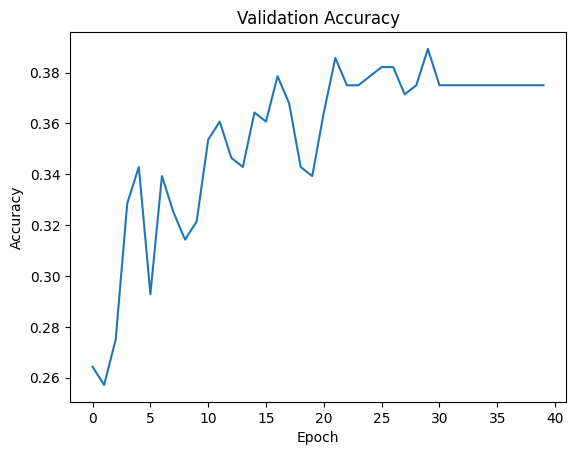

In [ ]:
# Load the model from the file
model = load_model('/content/drive/MyDrive/multiclass_vgg16_best_weights.h5')

# Extract the validation accuracy from the history object
val_acc = history.history['val_accuracy']
print(max(val_acc))

# Plot the validation accuracy over the course of training
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_generator.reset()
test_predictions = model.predict(test_generator)

label_map = dict((v, k) for k, v in test_generator.class_indices.items())
print(label_map)

actualLables_test = [label_map[k] for k in test_generator.classes]
print("Length of actual validation labels:", len(actualLables_test))

# Convert the predictions to a one-hot encoded format
test_predictions = np.argmax(test_predictions, axis = 1)
predictedLables_test = [label_map[k] for k in test_predictions]

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
confusion_matrix = sk_confusion_matrix(actualLables_test, predictedLables_test)

print(confusion_matrix)

test_loss, test_accuracy=model.evaluate(test_generator, batch_size=1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

288/288 [==============================] - 4s 15ms/step
{0: 'CS', 1: 'D', 2: 'DD', 3: 'SevereCS', 4: 'VSCS'}
Length of actual validation labels: 288
[[12  8 29  3 10]
 [ 6 17 28  0  4]
 [ 7 11 54  0 11]
 [ 9  2 17  5  8]
 [ 3  3 12  3 26]]
288/288 [==============================] - 5s 16ms/step - loss: 1.3864 - accuracy: 0.3958
Test Loss:     1.386436939239502
Test Accuracy: 0.3958333432674408


# **Ensembling**

In [ ]:
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_resnet50_best_weights.h5')
xception_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_xception_best_weights.h5')
proposed_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')
inception_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_inceptionv3_best_weights.h5')
#vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/multiclass_vgg16_best_weights.h5')

In [ ]:
seg_test_folders = '/content/drive/MyDrive/val'

In [ ]:
from collections import Counter
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

In [ ]:
import cv2
true_value = []
combined_model_pred = []
xception_pred = []
resnet_pred = []
proposed_pred = []
inception_pred = []
vgg16_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(val_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255

        resnet_image_prediction = np.argmax(resnet_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_image_prediction)
        
        xception_image_prediction = np.argmax(xception_model.predict(np.array([img_normalized])))
        xception_pred.append(xception_image_prediction)
        
        inception_image_prediction = np.argmax(inception_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        '''
        vgg16_image_prediction = np.argmax(vgg16_model.predict(np.array([img_normalized])))
        vgg16_pred.append(vgg16_image_prediction)
        '''
        
        proposed_image_prediction = np.argmax(proposed_model.predict(np.array([img_normalized])))
        proposed_pred.append(proposed_image_prediction)
        
        #giving high priority if they all predict something different
        image_prediction = mode([resnet_image_prediction, proposed_image_prediction, xception_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [ ]:
classes = val_generator.class_indices.keys()
TP_count = [true_value[i] == combined_model_pred[i] for i in range(len(true_value))]
model_accuracy = np.sum(TP_count)/len(TP_count)
print('Model Accuracy', model_accuracy)

In [ ]:
import itertools
def clf_report(true_value, model_pred):
    classes = val_generator.class_indices.keys()
    classes = val_generator.class_indices.keys()
    TP_count = [true_value[i] == combined_model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    '''
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    '''

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
combined_model_pred = [c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.273972602739726


**Testing**

In [ ]:
model.load_weights('/content/drive/MyDrive/multiclass_proposed_best_weights.h5')

In [ ]:
# Make predictions on the validation data
predictions = model.predict(val_generator, steps=len(val_generator))

# Convert the predictions to a class label
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion_matrix = confusion_matrix(val_generator.classes, predicted_classes)
print(confusion_matrix)

In [ ]:
import matplotlib.pyplot as plt

# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the cells with the values
for i in range(num_classes):
    for j in range(num_classes):
        text = plt.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="w")

plt.show()

In [ ]:
test_dir = '/content/drive/MyDrive/multiclass_2022'

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (310, 310), batch_size = 1, class_mode = 'categorical', shuffle = False)

Found 41 images belonging to 5 classes.


In [ ]:
predictions = model.predict_geenrator(test_generator, steps = len(test_generator))

AttributeError: ignored